## Exploratory data analysis: COPA findings documents

- by Matt Jackson
- Feb. 8, 2024
- FOR INTERNAL TEAM USE ONLY -- NOT A FINISHED WORK PRODUCT 

Library imports

In [11]:
import pandas as pd 
import re
import os
from collections import Counter
import nltk
nltk.download("stopwords") #https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stops = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mbjackson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mbjackson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Text cleaning and preprocessing

These summary reports are very formulaic, with a header identifying COPA log number at the top of each page, roughly the same section headers in the same order, and instances of the same non-header boilerplate text (e.g. quotations from Rules, definitions of evidentiary standards like "preponderance of the evidence"). To focus specifically on the unique content of each document, it may make sense to remove that boilerplate where possible, leaving only the specifics of the particular complaint.

##### Thought: tabularize?

This also suggests that the documents could be converted into a more standard "data frame" representation, where each section header [Executive Summary, Involved Parties, etc. etc.] is a column, and the text in that section is the value for a cell in each column. (A JSON representation may be more appropriate than tabular data, since some sections have varying numbers of, say, officers or counts or findings). That may be more appropriate if particular sections are to be used as distinct predictors.)

If it's of interest to the lines of investigation you are pursuing, I can try to mock up what that table would look like

In [28]:
add_more_stops = False
findings_are_stops = False
if add_more_stops:
    # consider customizing the list of stopwords more to remove very common words
    custom_stops = ["officer", "chicago", "il", "illinois", "copa", "th", "",
                    "incident", "ms", "mrs", "mr", "ipra"]
    stops += custom_stops
if findings_are_stops:
    finding_stops = ["sustained", "not sustained", "unfounded", "exonerated"]
    stops += finding_stops

HEADERS = re.compile(
    r"independent police review authority|"
    r"civilian office of police accountability|"
    r"log#?\d+|"
    r"summary report of investigation|"
    r"executive summary|"
    r"involved parties|"
    r"allegations|"
    r"alleged that|"
    r"applicable rules and laws|"
    r"conclusion|"
    r"digital evidence|"
    r"documentary evidence|"
    r"legal standard|"
    r"preponderance of (the |)evidence|"
    r"more likely than not|"
    r"clear and convincing( evidence|)|"
    r"recommended (discipline|penalty)"
    r"violation noted"
    r"xxx*|bbb+|" #i think this is how some redactions get turned into .txt
    r"\_+"
    , re.IGNORECASE
)

header_test_str = """The Civilian Office of Police Accountability said that a 
                    preponderance of evidence standard represented whether it was 
                    more likely than not that an officer complied with Department rules."""

Import an individual file and clean it.

**Note:** Because many of the reports deal with allegations of prejudiced behavior, including racism, sexism, and homophobia, the language data includes several epithets and slurs. If we do plan on replacing / censoring / substituting any epithets in the original data, we would likely want to do it here, using `re.sub()`, *before* the words go into tf-idf. 

Particular epithets may be relevant to specific topics -- e.g. if anti-Black incidents surface as a topic, it makes sense to store "[N-word]" separately rather than grouping it as "[Expletive]" or "[Racial slur]". Also, if we plan on fine-tuning pre-existing embeddings such as the ones in GloVe, it may be advisable to keep the epithets in the data until a later stage.

In [29]:


def preprocess(data: str, 
               remove_stops=True, 
               lemmatize=True, 
               return_as_list=True):
    """Pre-process the contents of a .txt file."""
    data = re.sub('\n', ' ', data) 
    data = data.lower()
    data = re.sub(r'[^\w\s]|/|\_', '', data)
    data = re.sub(r'\d+', '', data) #remove all numbers
    data = re.sub(HEADERS, '', data)

    if return_as_list:
        data = data.split(" ")
        if remove_stops:
            data = [w for w in data if w not in stops]
            if lemmatize:
                data = [lemmatizer.lemmatize(w) for w in data]
        return data
    else:
        #TODO: remove stopwords using regex
        return data 
    
EXAMPLE_FILE = os.path.join(os.getcwd(), "text_files/1092650.txt")
with open(EXAMPLE_FILE, 'r') as f:
    data = ''.join(f.readlines())
processed_data = preprocess(data)

# count number of each word in this document if you want

# ctr = Counter(processed_data)
# print(ctr)
# print(len(ctr))

Import all text files and create a corpus of pre-processed strings of text, one per file

In [ ]:
def get_full_corpus():
    """
    Extract text from every .txt file in a folder.
    Returns (list): a corpus, with each document's text as a single long string
    """
    DIR = os.path.join(os.getcwd(), "text_files")
    print(DIR)

    corpus = []

    for i, filename in enumerate(os.listdir(DIR)):
        if i % 100 == 0:
            print(f"Extracting text from file {i}...")
        if filename.endswith(".txt"):
            filepath = os.path.join(DIR, filename)
            with open(filepath, 'r') as f:
                data = ''.join(f.readlines())
            #TODO: consider doing preprocessing step here
            data = re.sub('\n', ' ', data)
            corpus.append(data)

    print("Corpus text extraction complete")
    return corpus

corpus = get_full_corpus()


### Count and Vectorize

The scikit-learn CountVectorizer allows us to quickly count word frequency within documents and then store that information as a matrix, with labeled columns for each word. It also has a TfidfVectorizer, which quickly computes tf-idf (see PA3, CAPP 121).

Words and phrases that will be redundant across almost every report should be removed prior to topic modeling, since a word in every or almost every document is unhelpful for distinguishing which report contains which topic. (***Note: tf-idf will de facto do this -- strong argument in favor of using tf-idf***) The Chile paper set thresholds for minimum and max word frequency manually (I think at 15 and 400), which we should also be able to do, by inspection if necessary.

In [49]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

cvectorizer = CountVectorizer(stop_words=stops)
X = cvectorizer.fit_transform(corpus)
feature_names = cvectorizer.get_feature_names_out()

# Uncomment these to get entire list of words
# print(feature_names)
# print(X.toarray())

tvectorizer = TfidfVectorizer(stop_words=stops)
Y = tvectorizer.fit_transform(corpus)
tfeature_names = tvectorizer.get_feature_names_out()

print(tfeature_names)
print(Y.toarray()) #TODO: print whole array to .txt file to analyze it. remove all-0 columns?


['00' '000' '0000' ... 'ϲϰ' 'ϳθ' 'ϳϯ']
[[0.00206501 0.         0.         ... 0.         0.         0.        ]
 [0.00689553 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.03135483 0.         ... 0.         0.         0.        ]
 [0.00610907 0.         0.         ... 0.         0.         0.        ]
 [0.03557238 0.         0.         ... 0.         0.         0.        ]]


Count how many of each word there are across all documents

In [51]:
def one_big_counter(corpus: list[str]) -> Counter:
    """
    Inputs: corpus of text from text files
    Returns (Counter): count of each word.
    This will take about 2 seconds per 100 documents, or about 30-60 seconds
    for the entire text file corpus (n = 2,149)
    """
    big_counter = Counter()
    for i, text in enumerate(corpus):
        # if i % 100 == 0:
        #     print(f"Counting text {i}...")
        text_list = preprocess(text)
        this_counter = Counter(text_list)
        big_counter += this_counter
    return big_counter 

ctr = one_big_counter(corpus)
print(ctr.most_common())

[('subject', 78105), ('officer', 55551), ('vehicle', 41158), ('stated', 39764), ('police', 32394), ('b', 25539), ('report', 24441), ('log', 23972), ('att', 22667), ('allegation', 21029), ('rule', 20740), ('civilian', 20093), ('time', 19997), ('sergeant', 19073), ('department', 18949), ('evidence', 17472), ('witness', 15911), ('stop', 15820), ('car', 15759), ('approximately', 14614), ('weapon', 13982), ('statement', 13882), ('involved', 13823), ('sgt', 13517), ('violation', 13442), ('attachment', 13397), ('also', 13312), ('one', 13095), ('c', 13026), ('force', 12767), ('told', 12562), ('hand', 12406), ('arrest', 12347), ('order', 12108), ('date', 12056), ('search', 11821), ('without', 11817), ('back', 11731), ('observed', 11658), ('gun', 11654), ('male', 11613), ('e', 11536), ('person', 11443), ('member', 11223), ('see', 11001), ('related', 10964), ('street', 10893), ('pm', 10681), ('investigation', 10546), ('said', 10525), ('firearm', 10506), ('scene', 10505), ('id', 10238), ('use', 99

Obtain how many words there are that occur with each frequency

[(1, 20765), (2, 5840), (3, 3176), (4, 2160), (5, 1558), (6, 1168), (7, 939), (8, 792), (9, 707), (10, 568), (11, 517), (12, 480), (13, 430), (14, 364), (15, 352), (16, 316), (18, 284), (17, 284), (19, 242), (20, 240), (21, 232), (22, 219), (24, 191), (23, 185), (26, 162), (25, 159), (29, 148), (27, 146), (31, 138), (28, 138), (30, 130), (35, 113), (32, 113), (33, 112), (36, 98), (38, 96), (37, 96), (34, 95), (41, 89), (40, 81), (45, 80), (43, 77), (42, 75), (49, 73), (46, 73), (39, 73), (47, 71), (55, 70), (44, 70), (50, 66), (52, 64), (48, 62), (51, 58), (68, 57), (58, 57), (62, 56), (54, 55), (53, 54), (57, 52), (56, 51), (66, 47), (59, 44), (61, 43), (64, 42), (63, 41), (75, 40), (67, 40), (86, 39), (60, 39), (112, 38), (70, 38), (82, 37), (81, 37), (72, 37), (71, 37), (69, 37), (65, 36), (80, 34), (78, 33), (83, 32), (76, 32), (79, 31), (102, 30), (96, 30), (93, 30), (92, 30), (89, 29), (85, 29), (100, 28), (90, 28), (77, 28), (109, 26), (97, 26), (95, 26), (88, 26), (74, 26), (73

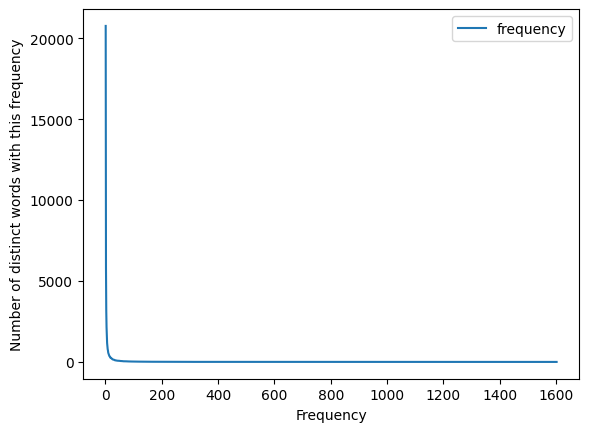

In [46]:

freq_distribution = Counter([i[1] for i in ctr.most_common()]).most_common()
print(freq_distribution)

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

x = np.linspace(1, 1602, num=1602)

ax.plot(x, [i[1] for i in freq_distribution], label="frequency")
plt.xlabel("Frequency")
plt.ylabel("Number of distinct words with this frequency")

plt.legend()
plt.show()

That's an awfully long tail. Let's truncate the graph to the words that appear between 10 and 200 times, say

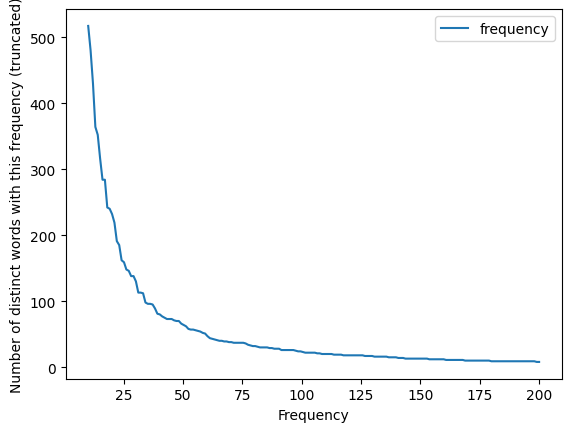

In [48]:
fig, ax = plt.subplots()

x2 = np.linspace(10, 200, num=190)

ax.plot(x2, [i[1] for i in freq_distribution][10:200], label="frequency")
plt.xlabel("Frequency")
plt.ylabel("Number of distinct words with this frequency (truncated)")

plt.legend()
plt.show()

Print literally every word

In [ ]:
for feature in feature_names:
    print(feature)

### Open question: Use findings as labels?

These reports have one of four "findings" for potential outcomes: **Sustained, Not Sustained, Unfounded,** and **Exonerated**. These are, effectively, labels that go with each allegation. Because these terms occur over and over again across all documents, they should be removed when doing topic modeling. However, we'd want to keep them in (or perhaps extract from relevant section and make a genuine label attribute out of them) if we want to pursue *supervised learning* NLP tasks, i.e. that predict whether certain kinds of allegations are more likely to be sustained, exonerated, etc. than others. (Or if some other trait of the report is correlated with report finding). 

This extraction would be a non-trivial amount of work. Additionally, some documents have multiple allegations, which would each need a separate label, and might be discussed in non-linear or intertwining ways.

### Note/Suggestion: IPRA vs. COPA

Early documents in the dataset are labeled "Independent Police Review Authority", or "IPRA", and have a somewhat different format. This is actually because a *predecessor* body was *replaced* by COPA a few years ago: "On October 5, 2016, the Chicago City Council passed an ordinance to establish COPA. On September 15, 2017, COPA officially opened." (https://www.chicagocopa.org/faqs/)

I am not currently that worried about the size of our dataset -- .txt files are pretty lightweight -- but the word representations could quickly get cumbersome with a large vocabulary, high-dimensional vector embeddings, etc. And the changeover from IPRA to COPA, which changed its institutional structure and powers, may coincide with heterogeneities in the data that make analysis more challenging. 

If at some future point the size of our data becomes a challenge, or we have difficulty drawing meaningful conclusions, **it *may* make sense to focus in on a smaller dataset of documents from COPA only**, i.e. from September 2017 or so onward (we can investigate actual files for the exact switchover/cutoff date). The changeover does also introduce some avenues for our investigation -- we could see if the corpus or balance of topics changes meaningfully before vs. after the change, or think of "regression discontinuity"-esque designs.

### Where this is headed

As discussed before, I am interested in exploring **topic modeling**, an unsupervised method for getting groups of words (or probability distributions of sets of words) that in some sense "go together", and determining the relative presence of each topic on a document-by-document basis. 
 
There are a few ways of doing this, with strengths and disadvantages:
- **Latent Dirichlet allocation (LDA)**. Has a subtype, **hierarchical latent Dirichlet allocation (hLDA)**, which groups topics under other topics
- **K-means clustering** on text data. 
- **BERTopic**: "leverages [HuggingFace] transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions." The main downside seems to be that it predicts *one* topic per document, rather than relative prevalence of each topic in each document.

Each of these can be implemented with relatively off-the-shelf functions available in established libraries. This includes pretty cool off-the-shelf data viz to visualize topics, their distance in conceptual space, etc.
If anything, it may be a little easy compared to what Amitabh is expecting (especially if he wants 700 lines of code and this can be set up in 5-20). Links/tutorials I'm looking at:
- LDA: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py 
- LDA: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
- K-means: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py
- LDA2vec: https://arxiv.org/abs/1605.02019
- LDA2vec: https://github.com/TropComplique/lda2vec-pytorch/blob/master/20newsgroups/explore_trained_model.ipynb
- BERTopic: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
- BERTopic: https://arxiv.org/pdf/2203.05794.pdf
- BERTopic: https://maartengr.github.io/BERTopic/index.html#citation

Depending on project scope and resources, we could try all of these and compare performance, or narrow in on the one that seems most feasible in the time we have. We will also want to vary some "hyperparameters" such as the total number $k$ of topics generated (most examples do between 4 and 10, it seems).

After doing this, we could assess how interpretable the topics are, whether they track common-sense differences in the kinds of misconduct residents might allege against police officers, and whether they correspond to distinctions made by COPA and the City of Chicago between different types of alleged police misconduct.

**Note:** These documents are pretty long, at least by comparison to other topic modeling examples I've looked at (they are longer than the complaints against the Carabineros police force in Chile, longer than several comment submissions in the CDO Council document, and much longer than tweets). It is worth paying close attention to how much training time and computing power is needed to set up these models, and thinking about using Colab GPU or other setup for especially long trainings if any. 